In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import dual_annealing as anneal_algo
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate 
import pysindy as ps

# Atmospheric attractor parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps*k1
mu2 = -eps*k2
alpha = -2.0
omega = 3.0

dt = 0.01
T = 500
t = np.arange(0,T+dt,dt)
tmax = len(t)-1

def oscillator_deriv(x_y_z, t0):
    x, y, z = x_y_z
    return [mu1*x + sigma*x*y, mu2*y + (omega + alpha*y + beta*z)*z - sigma*x**2, mu2*z - (omega + alpha*y + beta*z)*y]

x0_train = [0.1, -0.1, 0.1]
x_t = integrate.odeint(oscillator_deriv, x0_train, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0_train))

# Add some noise to the data
mean = 0.0
variance = 0.01
np.random.seed(502)
noise = np.random.normal(mean,variance,x_t.shape[0])
for i in range(r):
    x_t[:,i] = x_t[:,i] + noise

In [2]:
# Define all the complicated matrices in the optimization
poly_order = 2
Nr = int((r**2 + 3*r)/2.0)
mean = 0.0
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), int(r*(r**2+3*r)/2)))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0  # opt_m[k]  

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0  # opt_m[j]

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)

x, y, z = x_t.T

if poly_order == 2:
    library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
    library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
else:
    library_functions = [lambda x:x]
    library_function_names = [lambda x:x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                    function_names=library_function_names)

In [40]:
# Define the hyperparams and perform the optimization (regular prox-gradient)
eta = 1.0e6
gamma = 1.0e-3
beta = 0.5
threshold = 0.0
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, alpha_m=gamma, alpha_A=beta, vtol=1e-8, accel=True,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=400, tol=1e-10,
                            thresholder="l1", eigmin=-1e50, eigmax=-0.1,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")

model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
model.fit(x_t, t=t)
Xi = model.coefficients().T

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print('proxgrad, As eigvals: ', eigvals)
print(opt_m)
smallest_eigval = np.sort(eigvals)[0]
largest_eigval = np.sort(eigvals)[-1]
L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(d, Rm)

model.print()
print(np.dot(constraint_matrix, (sindy_opt.history_[0]).T.flatten()))
print(np.dot(constraint_matrix, (sindy_opt.history_[1]).T.flatten()))

37749.495840374715 2.538652842341664e-09 0.0
37750.112621571345 3.784342205972161e-09 0.0
37750.112621571345 3.784294838184195e-09 0.0
37750.112621571345 3.78429540423849e-09 0.0
37750.11262157136 3.7842958497465454e-09 0.0
37750.11262157135 3.78429581487905e-09 0.0
proxgrad, As eigvals:  [-0.74483791 -0.09999993 -0.01300235]
[ 0.00807955 -0.12919826  0.05070573]
[ 0.00044287  0.00176444 -0.00066704] 0.014665082614144048
x0' = 0.048 x0 + -0.003 x1 + -0.001 x2 + 1.150 x0x1 + 0.017 x0x2 + -0.004 x1x2 + -0.009 x1x1 + 0.001 x2x2
x1' = 0.015 x0 + -0.012 x1 + 2.968 x2 + 0.009 x0x1 + 0.081 x0x2 + -1.935 x1x2 + -1.150 x0x0 + -4.939 x2x2
x2' = 0.008 x0 + -2.965 x1 + -0.009 x2 + -0.077 x0x1 + -0.001 x0x2 + 4.939 x1x2 + -0.017 x0x0 + 1.935 x1x1
[-0.00495633 -0.04421881  0.00459412  0.08379232  0.0165494   0.07478253
 -0.13874134 -0.02537259  0.05754624  0.11900496]
[ 7.85189374e-17 -1.92009988e-16 -6.88104062e-16 -1.05471187e-15
  1.11022302e-15  1.77635684e-15  4.44089210e-16  2.22044605e-16
 -8

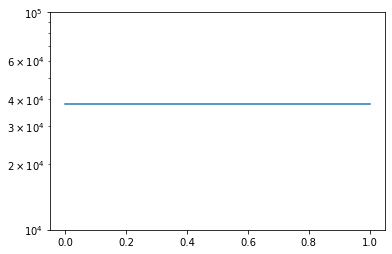

In [41]:
plt.figure(200)
plt.semilogy(sindy_opt.objective_history[2:])

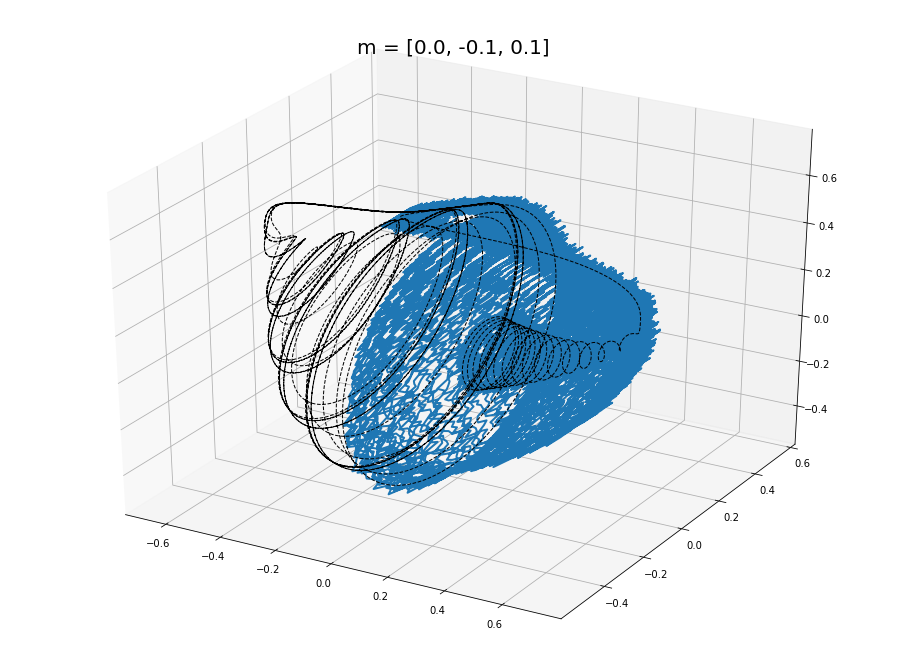

In [42]:
# Plot the results
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'},figsize=(16,12))
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=2)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x0_train, t, integrator_kws=integrator_keywords)
if np.all(eigvals < 0.0):
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'k--', linewidth=1)
    ax.set_title('m = [{0:.1f}, '.format(opt_m[0]) + '{0:.1f}, '.format(opt_m[1]) + '{0:0.1f}]'.format(opt_m[2]), fontsize=20)
else:
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'g--', linewidth=2)



In [ ]:
# Check energy-preserving constraint is satisfied (Qijk + Qjik + Qkij = 0)
# and Cw = d

Ls = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [0, 2, 1]) + np.transpose(Q, [2, 1, 0]))
print(Q + np.transpose(Q, [0, 2, 1]) + np.transpose(Q, [2, 1, 0]))
print(np.dot(constraint_matrix, Xi.flatten()))

In [ ]:
# Repeat with accelerated prox-gradient descent
# Define the hyperparams and perform the optimization (regular prox-gradient)
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, alpha_m=gamma, alpha_A=beta, vtol=1e-5, accel=True,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=40000, tol=1e-10,
                            thresholder="l1", eigmin=-1e50, eigmax=-1e-5,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")

model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
model.fit(x_t, t=t)
Xi = model.coefficients().T

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print('proxgrad, As eigvals: ', eigvals)
print(opt_m)
smallest_eigval = np.sort(eigvals)[0]
largest_eigval = np.sort(eigvals)[-1]
L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(d, Rm)

model.print()
print(np.dot(constraint_matrix, (sindy_opt.history_[0]).T.flatten()))
print(np.dot(constraint_matrix, (sindy_opt.history_[1]).T.flatten()))

In [ ]:
# Plot the results
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'},figsize=(16,12))
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=2)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x0_train, t, integrator_kws=integrator_keywords)
if np.all(eigvals < 0.0):
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'k--', linewidth=1)
    ax.set_title('m = [{0:.1f}, '.format(opt_m[0]) + '{0:.1f}, '.format(opt_m[1]) + '{0:0.1f}]'.format(opt_m[2]), fontsize=20)
else:
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'g--', linewidth=2)

plt.figure(200)
plt.semilogy(sindy_opt.objective_history[1:])

### Note accelerated prox-gradient only took 5 steps instead of ~4000!!